# Experiment: Gesture Classification with Deep Learning

In this experiment, a neural network model is trained with EMG data from the 65HDsEMG database to classify gestures. Here, a subset of the EMG channels is used to have the configuration/organization of that of the armband developed for this project. The data are divided into training and validation data to train the model, and into test data to evaluate the classification performance of the trained model.

# Signal preprocessing

The folowing 4-step preprocessing is applied to the EMG signal data:
1. Rectification
2. Teager-Kaiser Energy Operator (TKE)
3. Moving Average (30 samples)
4. Normalization

The normalization step is applied during the training while the other ones have already been applied to the data. 

## Table of Contents

- [0. Import libraries](#0)
- [1. Config Variables and hyperparameters](#1)
- [2. Load dataset with dataloader](#2)
- [3. Create model to train](#3)
- [4. Training](#4)
- [5. Evaluate best model](#5)
- [6. Save the model in .H5 file](#6)


<a name="0"></a>
# Import Libraries

In [1]:
import os, sys

processing_source_path = os.path.abspath('./../../../Processing/')
if(processing_source_path not in sys.path):
    sys.path.append(processing_source_path)
import ProcessingPipeline as pp

dataloader_source_path = os.path.abspath('./../../../Dataloader/')
if(dataloader_source_path not in sys.path):
    sys.path.append(dataloader_source_path)
from EMGGestureDataGen import EMGGestureDataGen

dataloader_source_path = os.path.abspath('./../../../Dataloader/')
if(dataloader_source_path not in sys.path):
    sys.path.append(dataloader_source_path)
from EMGGestureDataGen import EMGGestureDataGen
from KerasDataPipeline import KerasDataPipeline

model_source_path = os.path.abspath('./../../../Keras_deep_models/')
if(model_source_path not in sys.path):
    sys.path.append(model_source_path)
from EMGConv2DResNetModel import EMGConv2DResNetModel

dataloader_source_path = os.path.abspath('./../../../Utils/')
if(dataloader_source_path not in sys.path):
    sys.path.append(dataloader_source_path)
import utils as utils
import available_metrics as metrics

In [2]:
import numpy as np
from os.path import join
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import json

In [3]:
import tensorflow as tf
print(tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.8.0
1 Physical GPUs, 1 Logical GPUs


2023-11-23 16:54:59.244880: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 16:54:59.738236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 73748 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


<a name="1"></a>
# Config Variables and hyperparameters

In [4]:
# model_name = 'EMG65_2D_CNN_multiclass_armband_onesubject20230627_194533'
model_name = None

In [5]:
if model_name is None:
    print('Crate new config model')
    data_params = {
        "checkpoint_path": "trainings/",
        "database_path": "65HD_gestures_comparison2_balanced",
        "training_name": 'EMG65_2D_CNN_multiclass_armband' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S"),
        "img_width": 8,
        "img_height": 8,
        "num_features": 256,
        "window_step": 12,
    }
    training_params = {
        "early_stopping_patient": 10,
        "epochs": 200,
        "batch_size": 256,
        "lr": 0.01,
        "loss": 'CatCE',
        "filter_divisor": 4,
    }
    model_params = {
        "model_output_mode": 'multiclass',
        "print_model": True,
        "network_name": 'Resnet2D',
        "optimizer": 'adamW',
        "channels": 128,
    }
    # Combine all categories into a single dictionary
    config_model = {**data_params, **model_params, **training_params}
    
    try:
        with open(join('/root/data/data', config_model['database_path'], 'train', 'dataset_param.json')) as json_file:
            dataset_param = json.load(json_file)
            config_model['num_classes'] = len(dataset_param['dataset']['gestures'])
    except:
         config_model['num_classes'] = 10
else:
    config_path = join('trainings/', model_name, 'training_param.json')
    print('Loading config model from:', config_path)
    with open(config_path) as json_file:
        config_model = json.load(json_file)
    
print(config_model)

Crate new config model
{'checkpoint_path': 'trainings/', 'database_path': '65HD_gestures_comparison2_balanced', 'training_name': 'EMG65_2D_CNN_multiclass_armband20231123_165459', 'img_width': 8, 'img_height': 8, 'num_features': 256, 'window_step': 12, 'model_output_mode': 'multiclass', 'print_model': True, 'network_name': 'Resnet2D', 'optimizer': 'adamW', 'channels': 128, 'early_stopping_patient': 10, 'epochs': 200, 'batch_size': 256, 'lr': 0.01, 'loss': 'CatCE', 'filter_divisor': 4, 'num_classes': 10}


In [6]:
dataset_path = join('/root/data/data', config_model['database_path'])
num_gestures = config_model['num_classes']
window_size = config_model['num_features']
window_step = config_model['window_step']
img_width = config_model['img_width']
img_height = config_model['img_height']
batch_size = config_model['batch_size']
num_emg_channels = config_model['channels']

In [7]:
try:
    with open(join(dataset_path, 'train', 'dataset_param.json')) as json_file:
        dataset_param = json.load(json_file)
        gesture_list = dataset_param['dataset']['gestures']
        print(dataset_param)
except:
    gesture_list =[0, 13, 14, 17, 20, 36, 58, 59, 63, 64]
gesture_list, len(gesture_list)

([0, 13, 14, 17, 20, 36, 58, 59, 63, 64], 10)

In [8]:
config_model['gesture_list'] = gesture_list
config_model['num_classes'] = len(gesture_list)

<a name="2"></a>
# Load dataset with dataloader

In [9]:
data_processing = pp.ProcessingPipeline([
    pp.NormMinMax(axis=-1),
    pp.DataReshape((img_width, img_height, window_size)),
    pp.LabelOneHot(np.sort(gesture_list)) # to multiclass 
    ])

train_dataset = EMGGestureDataGen(join(dataset_path, 'train/'), batch_size, window_size, window_step, num_emg_channels, processing=data_processing, armband=True, dataset_name='65HDsEMG')
val_dataset = EMGGestureDataGen(join(dataset_path, 'val/'), batch_size, window_size, window_step, num_emg_channels, processing=data_processing, armband=True, dataset_name='65HDsEMG')
test_dataset = EMGGestureDataGen(join(dataset_path, 'test/'), batch_size, window_size, window_step, num_emg_channels, processing=data_processing, armband=True, dataset_name='65HDsEMG')

In [10]:
# # UNCOMMENT TO USE CLASS WEIGHTS
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced', classes=np.arange(len(gesture_list)), y=train_dataset.yData)
# config_model['class_weights'] = dict(enumerate(class_weights))

In [11]:
train_dataset_pipeline = KerasDataPipeline(train_dataset, (None, img_width, img_height, window_size), [None, config_model['num_classes']])
val_dataset_pipeline = KerasDataPipeline(val_dataset, (None, img_width, img_height, window_size), [None, config_model['num_classes']])

<a name="3"></a>
# Create model to train

In [12]:
emg_model = EMGConv2DResNetModel(config_model)
emg_model.load_model()

path False
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 256)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 32)     73760       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 32)    128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 8, 8, 32)     0           ['batch_normalizat

<a name="4"></a>
# Training

In [13]:
history = emg_model.train(train_dataset_pipeline.datasetPipeline, val_dataset_pipeline.datasetPipeline)

with open(join(config_model['checkpoint_path'], config_model['network_name'], 'training_param.json'), 'w') as fp:
    json.dump(config_model, fp, indent=4)

no weights
trainings/Resnet2D
Epoch 1/200


2023-11-23 16:55:55.924122: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400
2023-11-23 16:55:56.964509: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-23 16:57:29.689617: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trainings/Resnet2D/assets
814/814 - 118s - loss: 1.7430 - categorical_accuracy: 0.3860 - val_loss: 3.7679 - val_categorical_accuracy: 0.1017 - 118s/epoch - 145ms/step
Epoch 2/200
INFO:tensorflow:Assets written to: trainings/Resnet2D/assets
814/814 - 93s - loss: 1.4482 - categorical_accuracy: 0.4957 - val_loss: 1.0744 - val_categorical_accuracy: 0.6430 - 93s/epoch - 114ms/step
Epoch 3/200
INFO:tensorflow:Assets written to: trainings/Resnet2D/assets
814/814 - 98s - loss: 1.3148 - categorical_accuracy: 0.5468 - val_loss: 1.0443 - val_categorical_accuracy: 0.6577 - 98s/epoch - 120ms/step
Epoch 4/200
814/814 - 102s - loss: 1.2290 - categorical_accuracy: 0.5788 - val_loss: 1.0521 - val_categorical_accuracy: 0.6529 - 102s/epoch - 125ms/step
Epoch 5/200
INFO:tensorflow:Assets written to: trainings/Resnet2D/assets
814/814 - 104s - loss: 1.1654 - categorical_accuracy: 0.6025 - val_loss: 0.9126 - val_categorical_accuracy: 0.7015 - 104s/epoch - 128ms/step
Epoch 6

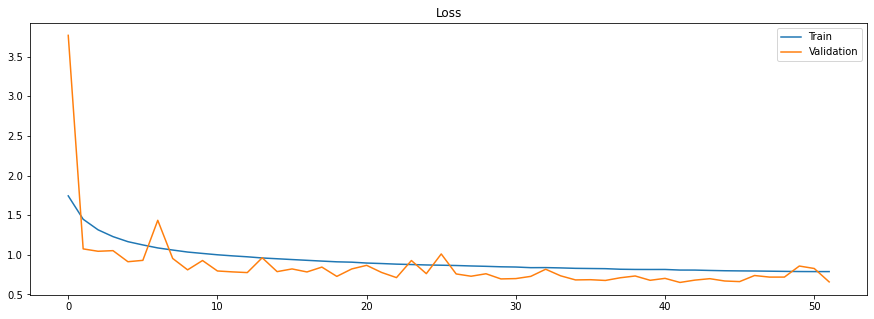

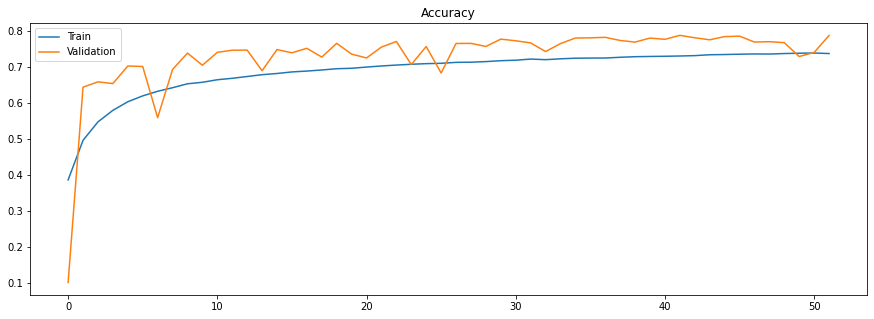

In [14]:
from pandas import read_csv
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.title("Loss")
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

plt.figure(figsize=(15,5))
plt.title("Accuracy")
plt.plot(history.history['categorical_accuracy'], label='Train')
plt.plot(history.history['val_categorical_accuracy'], label='Validation')
plt.legend()

<a name="5"></a>
# Evaluate best model

In [16]:
import tensorflow_addons as tfa
# load best model
trained_deep_model = tf.keras.models.load_model(join(config_model['checkpoint_path'] + config_model['network_name']))

<a name="5-1"></a>
### Train Dataset

In [ ]:
test_performance = trained_deep_model.evaluate(train_dataset)
y_train, y_pred = utils.generate_data(train_dataset, trained_deep_model)

In [ ]:
pr, re, f1, acc=metrics.model_metrics(config_model['gesture_list'] ,y_train, y_pred, Get_metrics=True) 

In [ ]:
# available the train data 
cfm_deep_model=metrics.plot_confusion_matrix(config_model['gesture_list'], y_train, y_pred, Get_matrix=True)

<a name="5-2"></a>
### Test Dataset

In [17]:
test_performance = trained_deep_model.evaluate(test_dataset)
y_test, y_pred = utils.generate_data(test_dataset, trained_deep_model)

415/415 [==============================] - 43s 103ms/step - loss: 0.5477 - categorical_accuracy: 0.8308


100%|██████████| 415/415 [01:17<00:00,  5.36it/s]


In [18]:
pr, re, f1, acc=metrics.model_metrics(config_model['gesture_list'] ,y_test, y_pred, Get_metrics=True) 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     55012
          13       0.91      0.89      0.90      5877
          14       0.68      0.72      0.70      5544
          17       0.81      0.79      0.80      5547
          20       0.62      0.63      0.62      5637
          36       0.63      0.71      0.67      5793
          58       0.70      0.65      0.68      5648
          59       0.79      0.61      0.69      6003
          63       0.57      0.49      0.53      5720
          64       0.75      0.66      0.70      5459

    accuracy                           0.83    106240
   macro avg       0.74      0.71      0.72    106240
weighted avg       0.83      0.83      0.83    106240

Precision Score:  0.7391033459138227
Recall Score:  0.7123183616678928
F1-Score:  0.723523506990061
Accuracy:  0.8307699548192771


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


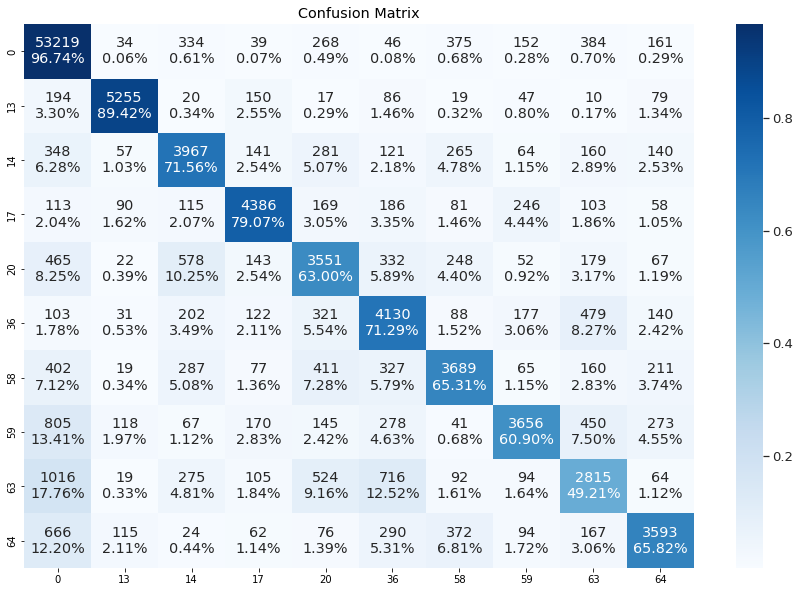

In [19]:
# available the test data 
cfm_deep_model=metrics.plot_confusion_matrix(config_model['gesture_list'], y_test, y_pred, Get_matrix=True)

#### Metrics with Average and std for each classes

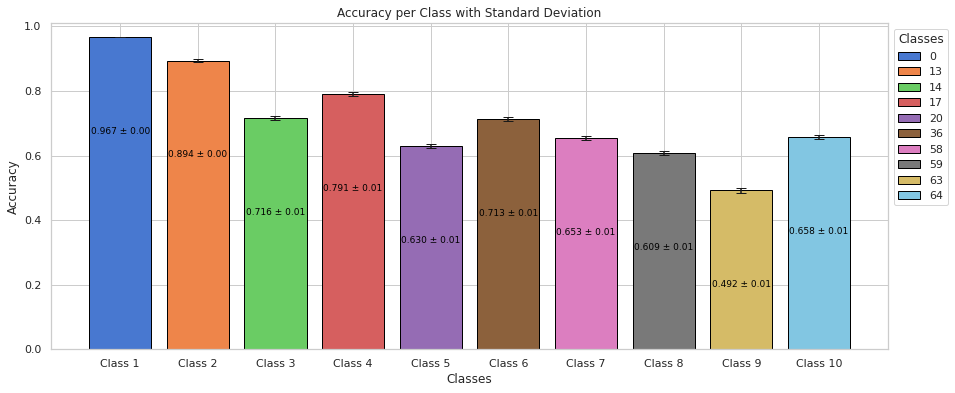

In [20]:
metrics.plot_metric_per_class(cfm_deep_model, config_model['gesture_list'], metric_name='Accuracy', method='per_class')

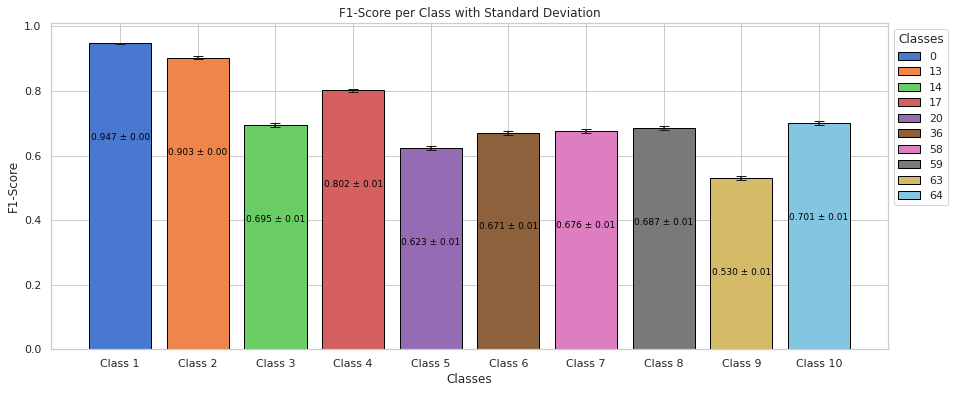

In [21]:
metrics.plot_metric_per_class(cfm_deep_model, config_model['gesture_list'], metric_name='F1-Score', method='per_class')

#### Mean and std for all Classes 

In [22]:
metrics_per_class,precision_list,recall_list,f1_score_list,accuracy_list=metrics.model_average_std_metrics(cf_matrix=cfm_deep_model, Get_metrics=True, Verbose=True) 

Precision Score: 0.7391±0.1152
Recall Score: 0.7123±0.1329
F1-Score: 0.7235±0.1199
Accuracy: 0.7123±0.1329


In [23]:
metrics_average_and_std_df=pd.DataFrame(data=[precision_list,recall_list,f1_score_list,accuracy_list],
             index=['pr', 're', 'f1', 'acc'],
             columns=['Average','std'])
metrics_average_and_std_df

,Average,std
pr,0.739103,0.115177
re,0.712318,0.132913
f1,0.723524,0.119928
acc,0.712318,0.132913


## ROC

ROC AUC for Class 0: 0.94357
ROC AUC for Class 1: 0.94457
ROC AUC for Class 2: 0.84833
ROC AUC for Class 3: 0.89034
ROC AUC for Class 4: 0.80398
ROC AUC for Class 5: 0.84461
ROC AUC for Class 6: 0.81872
ROC AUC for Class 7: 0.79957
ROC AUC for Class 8: 0.73566
ROC AUC for Class 9: 0.82317


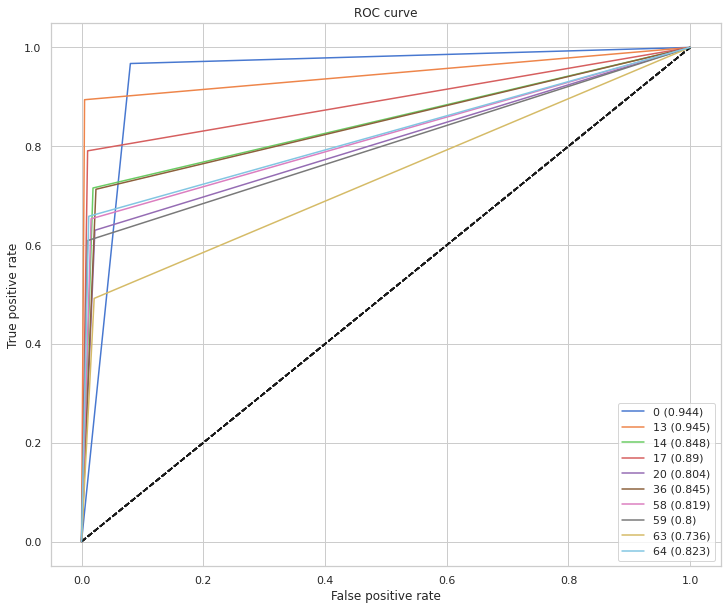

In [24]:
roc_score_per_class=metrics.get_roc_curve(config_model['gesture_list'], y_test, y_pred ,verbose=True)

In [25]:
# import mlflow_save_parameters_multiclass 

# mlflow_save_parameters_multiclass.save_data_in_mlflow("65HDsEMG_multiclass_armband", config_model, test_metric, data_processing.getProcessingNameList())

<a name="6"></a>
## Save the model in .H5 file

In [26]:
trained_deep_model.save(config_model['checkpoint_path'] +  config_model['network_name']+'/ResNet2D.h5')